# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

* анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы
* контролировать добросовестность кассиров при продаже алкоголя

Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. Доступен набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
labels = pd.read_csv('/datasets/faces/labels.csv')
datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [ ]:
labels.describe().T

,count,mean,std,min,25%,50%,75%,max
real_age,7591.0,31.201159,17.14506,1.0,20.0,29.0,41.0,100.0


Датасет содержит 7591 фотографий. 50% фотографий - это люди в возрасте 20-41 лет

array([[<AxesSubplot:title={'center':'real_age'}>]], dtype=object)

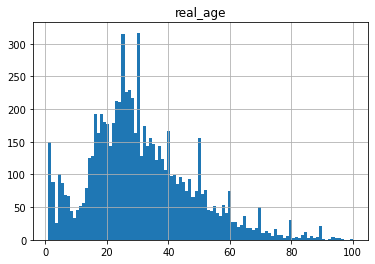

In [ ]:
labels.hist(bins=100)

В имеющемся датасете представлены дети, взрослые и пожилые люди. Имеется всплеск количества детей до 10 лет. И выбросы в годы, кратные 5 и 10 годам. Думаю это связано с некоторыми погрешностями при разметке части датасета (округлениями)

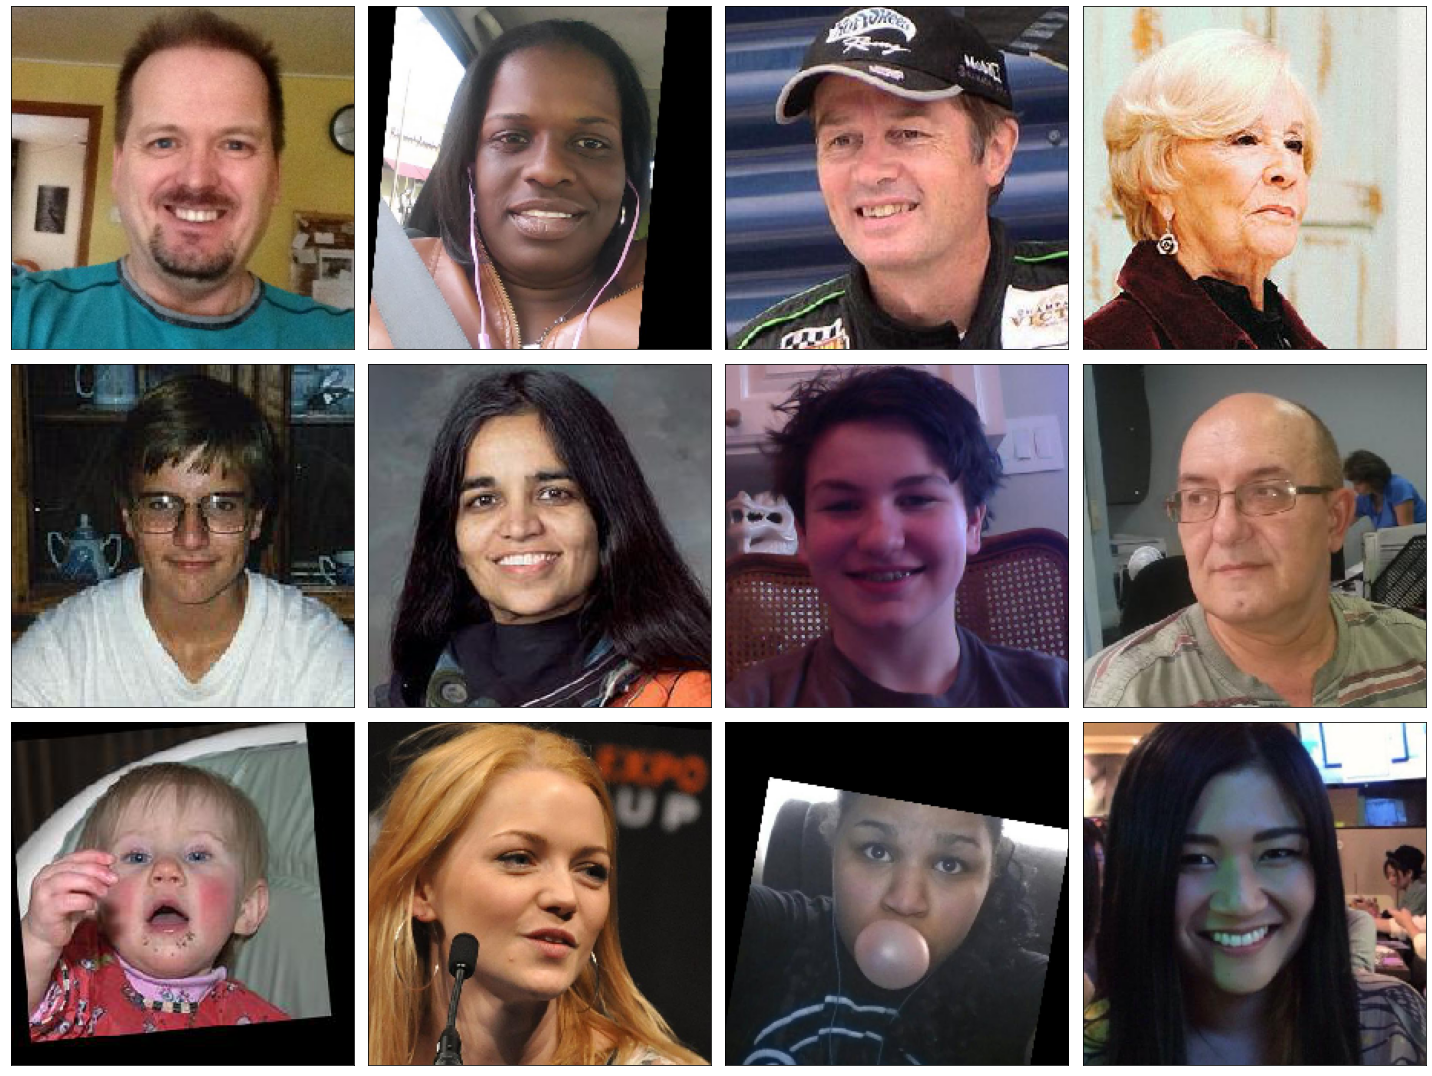

In [ ]:
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(20,20))
for i in range(12):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Фотографий в датасете мало, они разного качества — различное освещение, четкость, присутствие дополнительных деталей в кадре в районе лица, черно-белые фотографии, часть фотографий поворенутые, возможно с целью выравнивания линии глаз.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import tensorflow as tf


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow


def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])


    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=30,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

```

Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2022-06-27 21:20:18.400092: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s

2022-06-27 21:20:25.473858: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 30509 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)

Train for 356 steps, validate for 119 steps
Epoch 1/30
356/356 - 120s - loss: 206.0148 - mae: 10.3914 - val_loss: 326.3915 - val_mae: 13.4039
Epoch 2/30
356/356 - 39s - loss: 84.4111 - mae: 6.9929 - val_loss: 138.5609 - val_mae: 8.7387
Epoch 3/30
356/356 - 39s - loss: 55.4329 - mae: 5.7129 - val_loss: 78.0522 - val_mae: 6.6494
Epoch 4/30
356/356 - 39s - loss: 44.3828 - mae: 5.0815 - val_loss: 77.5353 - val_mae: 6.5030
Epoch 5/30
356/356 - 39s - loss: 32.6674 - mae: 4.4196 - val_loss: 66.7652 - val_mae: 6.0955
Epoch 6/30
356/356 - 39s - loss: 25.1909 - mae: 3.8187 - val_loss: 77.7275 - val_mae: 6.6593
Epoch 7/30
356/356 - 39s - loss: 20.9174 - mae: 3.4726 - val_loss: 70.5306 - val_mae: 6.1406
Epoch 8/30
356/356 - 39s - loss: 18.0745 - mae: 3.2375 - val_loss: 77.7024 - val_mae: 6.4312
Epoch 9/30
356/356 - 39s - loss: 15.8739 - mae: 3.0471 - val_loss: 73.0605 - val_mae: 6.3568
Epoch 10/30
356/356 - 39s - loss: 14.1748 - mae: 2.8495 - val_loss: 67.7537 - val_mae: 6.1248
Epoch 11/30
356/356 - 39s - loss: 13.4264 - mae: 2.7918 - val_loss: 62.2635 - val_mae: 5.7870
Epoch 12/30
356/356 - 39s - loss: 12.3518 - mae: 2.6817 - val_loss: 68.5977 - val_mae: 6.0528
Epoch 13/30
356/356 - 39s - loss: 11.4008 - mae: 2.5600 - val_loss: 77.7489 - val_mae: 6.6290
Epoch 14/30
356/356 - 39s - loss: 11.5237 - mae: 2.5786 - val_loss: 71.3886 - val_mae: 6.2502
Epoch 15/30
356/356 - 39s - loss: 10.7039 - mae: 2.4930 - val_loss: 67.7970 - val_mae: 6.1690
Epoch 16/30
356/356 - 39s - loss: 10.5296 - mae: 2.4636 - val_loss: 65.6930 - val_mae: 5.9557
Epoch 17/30
356/356 - 39s - loss: 9.8462 - mae: 2.3780 - val_loss: 60.9523 - val_mae: 5.8159
Epoch 18/30
356/356 - 39s - loss: 9.7371 - mae: 2.3586 - val_loss: 61.4130 - val_mae: 5.7626
Epoch 19/30
356/356 - 38s - loss: 9.5510 - mae: 2.3221 - val_loss: 67.7004 - val_mae: 6.1472
Epoch 20/30
356/356 - 39s - loss: 9.6876 - mae: 2.3496 - val_loss: 69.3793 - val_mae: 6.1492
Epoch 21/30
356/356 - 39s - loss: 8.8094 - mae: 2.2747 - val_loss: 62.4988 - val_mae: 5.8785
Epoch 22/30
356/356 - 39s - loss: 8.0310 - mae: 2.1455 - val_loss: 61.4088 - val_mae: 5.8514
Epoch 23/30
356/356 - 39s - loss: 7.6852 - mae: 2.0968 - val_loss: 63.0300 - val_mae: 5.8586
Epoch 24/30
356/356 - 39s - loss: 7.9475 - mae: 2.1112 - val_loss: 59.9310 - val_mae: 5.6687
Epoch 25/30
356/356 - 39s - loss: 7.8120 - mae: 2.1101 - val_loss: 64.7318 - val_mae: 5.8924
Epoch 26/30
356/356 - 39s - loss: 8.0175 - mae: 2.1565 - val_loss: 60.6672 - val_mae: 5.6882
Epoch 27/30
356/356 - 39s - loss: 6.9245 - mae: 1.9925 - val_loss: 58.1010 - val_mae: 5.6080
Epoch 28/30
356/356 - 39s - loss: 6.5565 - mae: 1.9179 - val_loss: 58.5490 - val_mae: 5.6480
Epoch 29/30
356/356 - 39s - loss: 5.6667 - mae: 1.8013 - val_loss: 60.8845 - val_mae: 5.6271
Epoch 30/30
356/356 - 39s - loss: 6.0186 - mae: 1.8464 - val_loss: 65.9874 - val_mae: 6.0795

119/119 - 10s - loss: 65.9874 - mae: 6.0795
Test MAE: 6.0795

```

Требуемое значение MAE достигнуто

## Анализ обученной модели

Применение ResNet50 позволило достичь заданного уровня метрики за 30 эпох. Размер батча 16. Было использовано переворот изображение по горизонтале. И поделена яркость на 255. Использован алгоритм Adam с шагом lr=0.0001. Функция ошибки MSE.

Внешний вид взрослого человека зависит от многих факторов и ошибка в 5-6 лет не значительная.

Итоговое MAE: 6.0795, что означает достижение заданой метрики.

Наша модель позволяет бизнесу определять примерный возраст покупателя и использовать рекомендательные системы для возрастной группы, а также контроль кассиров при продаже алкоголя.

